**N.B.** Pre-trained models for each of these cases are located in the `models` directory.

In [1]:
import numpy as np
import pandas as pd
import os, shutil, pathlib
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers, utils
from tensorflow.keras.utils import image_dataset_from_directory
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input

## Baseline Classifier

### Load model and weights

In [ ]:
input_shape = (533, 800, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

i = layers.Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=[i], outputs=[x])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.load_weights('/content/drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_cauc_only_31_08.keras')

### Plot training history

In [ ]:
history = pd.read_csv('/content/drive/My Drive/MSc Data Science/Dissertation/Logs/DenseNet121/dn121_cauc_only_31_08.csv')

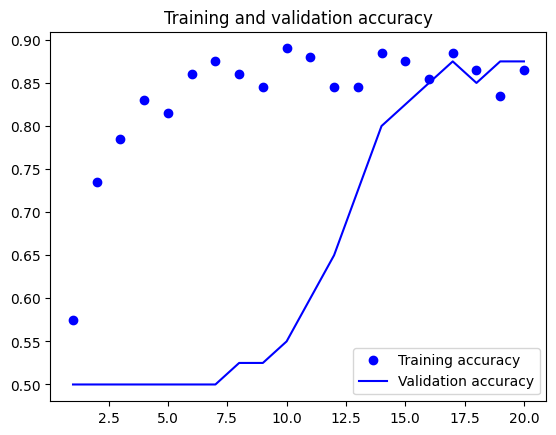

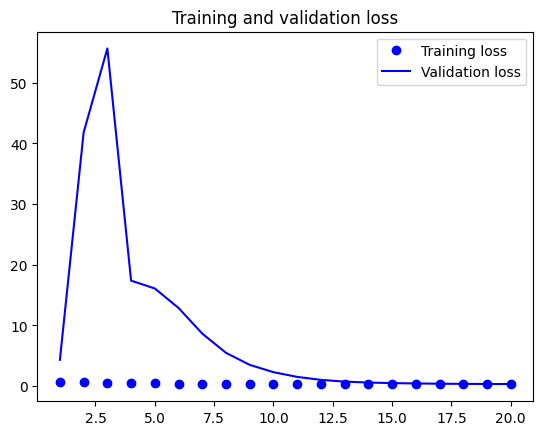

In [ ]:
accuracy = history["accuracy"]
val_accuracy = history["val_accuracy"]
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Test model performance

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_cauc_only_31_08.keras', compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

#### Overall Accuracy & AUC

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_ALL',
    image_size=(533, 800),
    batch_size=32)

Found 132 files belonging to 2 classes.


In [ ]:
# Result across whole test dataset
model.evaluate(test_dataset)

5/5 [==============================] - 274s 42s/step - loss: 0.8117 - accuracy: 0.6818 - auc: 0.6995


[0.8116597533226013, 0.6818181872367859, 0.6994949579238892]

#### Test on Caucasian samples
MESSIDOR-2 and HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_caucasian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Caucasian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 44s 11s/step - loss: 0.4605 - accuracy: 0.8636 - auc: 0.8595


[0.46050089597702026, 0.8636363744735718, 0.8595041036605835]

#### Test on Indian samples
IDRiD

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_indian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Indian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 44s 11s/step - loss: 0.4269 - accuracy: 0.7727 - auc: 0.9184


[0.4269423186779022, 0.7727272510528564, 0.9183884263038635]

#### Test on African samples
HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_african',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on African test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 41s 11s/step - loss: 0.6895 - accuracy: 0.6818 - auc: 0.7211


[0.6895178556442261, 0.6818181872367859, 0.7210743427276611]

## Debiased Classifier 1 - Augmentation Only
Add Indian DME samples generated by Patho-GAN.

### Load Data

In [ ]:
new_base_dir = pathlib.Path('drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small')

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(533, 800),
	label_mode='binary',
    shuffle=True,
    batch_size=8)
    #batch_size=16)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'val',
    image_size=(533, 800),
	label_mode='binary',
    shuffle=True,
    batch_size=8)
    #batch_size=16)

Found 200 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


### Build Model

In [ ]:
input_shape = (533, 800, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

i = layers.Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=[i], outputs=[x])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

### Train Model

In [ ]:
log_filename = 'drive/My Drive/MSc Data Science/Dissertation/Logs/DenseNet121/dn121_indian_aug.csv'
history_logger = tf.keras.callbacks.CSVLogger(log_filename, separator=",", append=True)
callbacks = [
    history_logger,
    keras.callbacks.ModelCheckpoint(
        #filepath="drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug.keras",
        filepath="drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug.tf",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)
]

num_epochs = 20

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=num_epochs,
                    callbacks=callbacks)

Epoch 1/20
25/25 [==============================] - 141s 3s/step - loss: 0.7301 - accuracy: 0.6700 - val_loss: 1.5937 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/20
25/25 [==============================] - 73s 3s/step - loss: 0.3831 - accuracy: 0.8350 - val_loss: 1.1909 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/20
25/25 [==============================] - 21s 832ms/step - loss: 0.2513 - accuracy: 0.8900 - val_loss: 1.3120 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/20
25/25 [==============================] - 22s 865ms/step - loss: 0.2187 - accuracy: 0.9100 - val_loss: 1.6588 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 5/20
25/25 [==============================] - 21s 812ms/step - loss: 0.1744 - accuracy: 0.9350 - val_loss: 1.3303 - val_accuracy: 0.5750 - lr: 1.0000e-05
Epoch 6/20
25/25 [==============================] - 72s 3s/step - loss: 0.2254 - accuracy: 0.9000 - val_loss: 0.9216 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 7/20
25/25 [==============================

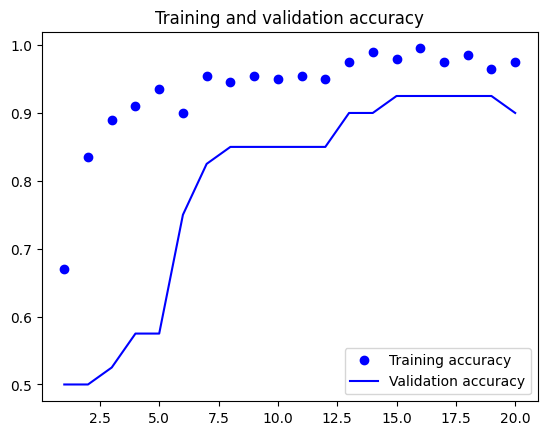

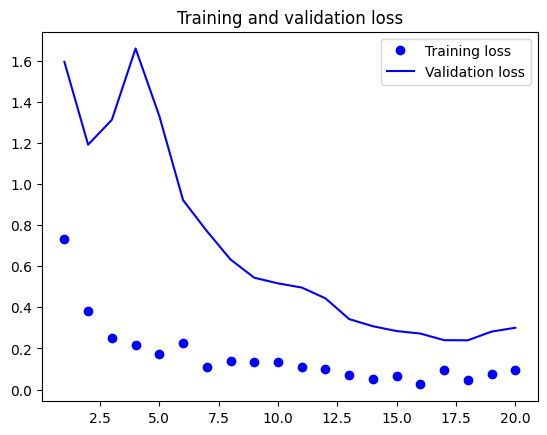

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Test model performance

In [ ]:
model = keras.models.load_model('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug.tf', compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

#### Overall Accuracy & AUC

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_ALL',
    image_size=(533, 800),
    batch_size=32)

Found 132 files belonging to 2 classes.


In [ ]:
# Result across whole test dataset
model.evaluate(test_dataset)

5/5 [==============================] - 45s 1s/step - loss: 0.9030 - accuracy: 0.6515 - auc: 0.7142


[0.9030006527900696, 0.6515151262283325, 0.7141873240470886]

#### Test on Caucasian samples
MESSIDOR-2 and HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_caucasian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Caucasian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 5s 373ms/step - loss: 0.6913 - accuracy: 0.7500 - auc: 0.8678


[0.6913249492645264, 0.75, 0.8677685856819153]

#### Test on Indian samples
IDRiD

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_indian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Indian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 3s 289ms/step - loss: 0.5586 - accuracy: 0.7273 - auc: 0.9638


[0.5586398839950562, 0.7272727489471436, 0.963843047618866]

#### Test on African samples
HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_african',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on African test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 2s 291ms/step - loss: 0.7706 - accuracy: 0.7045 - auc: 0.7531


[0.7705780267715454, 0.7045454382896423, 0.7530992031097412]

## Debiased Classifier 2 - Adversarial Debiasing Only

### Load model and weights

In [ ]:
input_shape = (533, 800, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

i = layers.Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=[i], outputs=[x])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.load_weights('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_cauc_only/clf.keras')

In [ ]:
model = keras.models.load_model('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_cauc_only/clf.keras', compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

### Test model performance

#### Overall Accuracy & AUC

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_ALL',
    image_size=(533, 800),
    batch_size=32)

Found 132 files belonging to 2 classes.


In [ ]:
# Result across whole test dataset
model.evaluate(test_dataset)

5/5 [==============================] - 236s 40s/step - loss: 0.7864 - accuracy: 0.6439 - auc: 0.6930


[0.7863903045654297, 0.6439393758773804, 0.6929522752761841]

#### Test on Caucasian samples
MESSIDOR-2 and HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_caucasian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Caucasian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 58s 11s/step - loss: 0.5008 - accuracy: 0.7727 - auc: 0.8533


[0.500807523727417, 0.7727272510528564, 0.8533058166503906]

#### Test on Indian samples
IDRiD

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_indian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Indian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 50s 11s/step - loss: 0.4747 - accuracy: 0.8182 - auc: 0.9132


[0.474718302488327, 0.8181818127632141, 0.913223147392273]

#### Test on African samples
HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_african',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on African test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 53s 11s/step - loss: 0.7419 - accuracy: 0.6591 - auc: 0.7180


[0.7418762445449829, 0.6590909361839294, 0.7179751992225647]

## Debiased Classifier 3 - TARA
Augmentation + Adversarial Debiasing.

### Load Data

In [ ]:
## Helper Functions
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size) # PIL Image
    array = keras.utils.img_to_array(img) # NumPy Array
    array = np.expand_dims(array, axis=0) # "Batch"
    return array

## N.B. Ethnicity: 1 = Caucasian, 0 = Indian
## DME: 1 = DME, 0 = Healthy

## Process Data

# Train

train_dir_dme = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/train/dme'
train_dir_healthy = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/train/healthy'

X_train_imgs = []
y_train = []
z_train = []

for img_dir in [train_dir_dme, train_dir_healthy]:
  for img in os.listdir(img_dir):
    img_array = get_img_array(os.path.join(img_dir, img), (533, 800))
    X_train_imgs.append(img_array)
    if img_dir==train_dir_dme:
        y_train.append(1)
    else:
        y_train.append(0)
    if 'IDRiD' in img:
        z_train.append(0)
    else:
        z_train.append(1)

# Images
X_train_imgs = np.array(X_train_imgs)
X_train_imgs = X_train_imgs.reshape(X_train_imgs.shape[0], 533, 800, 3)
# DME labels
y_train = pd.DataFrame(np.array(y_train))
y_train.head(2)
# Ethnicity labels (protected characteristic)
z_train = np.array(z_train)
Z_train = pd.DataFrame(z_train)
Z_train.head(2)

# Validation

val_dir_dme = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/val/dme'
val_dir_healthy = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/val/healthy'

X_val_imgs = []
y_val = []
z_val = []

for img_dir in [val_dir_dme, val_dir_healthy]:
  for img in os.listdir(img_dir):
    img_array = get_img_array(os.path.join(img_dir, img), (533, 800))
    X_val_imgs.append(img_array)
    if img_dir==val_dir_dme:
        y_val.append(1)
    else:
        y_val.append(0)
    if 'IDRiD' in img:
        z_val.append(0)
    else:
        z_val.append(1)

# Images
X_val_imgs = np.array(X_val_imgs)
X_val_imgs = X_val_imgs.reshape(X_val_imgs.shape[0], 533, 800, 3)
# DME labels
y_val = pd.DataFrame(np.array(y_val))
y_val.head(2)
# Ethnicity labels (protected characteristic)
z_val = np.array(z_val)
Z_val = pd.DataFrame(z_val)
Z_val.head(2)

,0
0,1
1,1


### Classifier

In [ ]:
# CLASSIFIER
input_shape = (533, 800, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

clf_inputs = layers.Input(shape=input_shape)
x = preprocess_input(clf_inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
clf_outputs = layers.Dense(1, activation='sigmoid')(x)
clf = models.Model(inputs=[clf_inputs], outputs=[clf_outputs])

clf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
clf.load_weights('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug.tf')

### Adversary

In [ ]:
# ADVERSARY
for i in range(2):
    clf.layers[i].trainable = False

ll = clf.layers[2].output
ll = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(ll)
ll = layers.MaxPooling2D(pool_size=2)(ll)
ll = layers.Flatten()(ll)
adv_outputs = layers.Dense(1, activation="sigmoid")(ll)

adv = keras.Model(inputs=clf.input,outputs=adv_outputs)

adv.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# # Pre-train adversary
# callbacks = [keras.callbacks.ModelCheckpoint(filepath='drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug_adv.tf', save_best_only=True, monitor='val_loss')]
# adv.fit(X_train_imgs, Z_train.values.astype('float32'), validation_data=(X_val_imgs, Z_val.values.astype('float32')), epochs=5, batch_size=8, callbacks=callbacks)

# Load pre-trained weights
adv.load_weights('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug_adv.tf')

### Combined Model

In [ ]:
# Combined Model
clf_w_adv = keras.Model(inputs=[clf_inputs], outputs=[clf_outputs+adv_outputs])

In [ ]:
def make_trainable(net, flag):
  net.trainable = flag
  for layer in net.layers:
      layer.trainable = flag
  return net

In [ ]:
make_trainable(clf, True)
make_trainable(adv, False)
clf_w_adv.compile(loss=['binary_crossentropy'], optimizer='adam')

In [ ]:
n_iter = 5
batch_size = 8

In [ ]:
# os.mkdir('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_TARA')

In [ ]:
for idx in range(n_iter):
  # train adversarial
  make_trainable(clf, False)
  make_trainable(adv, True)
  adv.fit(X_train_imgs, Z_train.values.astype('float32'),
          validation_data=(X_val_imgs, Z_val.values.astype('float32')),
          batch_size=batch_size, epochs=1)

  # train classifier
  make_trainable(clf, True)
  make_trainable(adv, False)
  clf_w_adv.fit(X_train_imgs, [y_train.values]+np.hsplit(Z_train.values.astype('float32'), Z_train.values.shape[1]), validation_data=(X_val_imgs, [y_val.values]+np.hsplit(Z_val.values.astype('float32'), Z_val.values.shape[1])), batch_size=batch_size, epochs=5)

  # save models
  clf.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_TARA/clf.keras')
  adv.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_TARA/adv.keras')
  clf_w_adv.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_TARA/clf_w_adv.keras')

25/25 [==============================] - 12s 84ms/step - loss: 1.2387e-10 - accuracy: 1.0000 - val_loss: 1.3705e-09 - val_accuracy: 1.0000
Epoch 1/5
25/25 [==============================] - 105s 908ms/step - loss: 7.7058 - val_loss: 11.4809
Epoch 2/5
25/25 [==============================] - 20s 800ms/step - loss: 7.6246 - val_loss: 11.4809
Epoch 3/5
25/25 [==============================] - 20s 796ms/step - loss: 7.6246 - val_loss: 11.4809
Epoch 4/5
25/25 [==============================] - 20s 790ms/step - loss: 7.6246 - val_loss: 11.4809
Epoch 5/5
25/25 [==============================] - 2s 75ms/step - loss: 1.2387e-10 - accuracy: 1.0000 - val_loss: 1.3705e-09 - val_accuracy: 1.0000
Epoch 1/5
25/25 [==============================] - 20s 808ms/step - loss: 7.6246 - val_loss: 8.3397
Epoch 2/5
25/25 [==============================] - 20s 798ms/step - loss: 7.6246 - val_loss: 7.6257
Epoch 3/5
25/25 [==============================] - 20s 789ms/step - loss: 7.6246 - val_loss: 7.6247
Epoch 4/

### Test Model Performance

#### Load model and weights

In [ ]:
input_shape = (533, 800, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

i = layers.Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=[i], outputs=[x])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# model.load_weights('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_TARA/clf.keras')
model = keras.models.load_model('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_TARA/clf.keras', compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

#### Test on Caucasian samples
MESSIDOR-2 and HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_caucasian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Caucasian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 5s 279ms/step - loss: 3.3432 - accuracy: 0.6136 - auc: 0.5826


[3.3432281017303467, 0.6136363744735718, 0.5826447010040283]

#### Test on Indian samples
IDRiD

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_indian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Indian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 3s 275ms/step - loss: 3.1181 - accuracy: 0.6136 - auc: 0.5702


[3.118126153945923, 0.6136363744735718, 0.5702479481697083]

#### Test on African samples
HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_african',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on African test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 1s 278ms/step - loss: 6.4844 - accuracy: 0.5000 - auc: 0.5000


[6.484423637390137, 0.5, 0.5]

## Debiased Classifier 3 - TARA+F
Augmentation + Adversarial Debiasing. Exclude GAN samples when training adversary.

### Load Data

In [ ]:
## Helper Functions
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size) # PIL Image
    array = keras.utils.img_to_array(img) # NumPy Array
    array = np.expand_dims(array, axis=0) # "Batch"
    return array

## N.B. Ethnicity: 1 = Caucasian, 0 = African
## DME: 1 = DME, 0 = Healthy

## Process Data

# Train

train_dir_dme = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/train/dme'
train_dir_healthy = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/train/healthy'

X_train_imgs = []
X_train_imgs_cauc = []
y_train = []
y_train_cauc = []
z_train = []
z_train_cauc = []

for img_dir in [train_dir_dme, train_dir_healthy]:
  for img in os.listdir(img_dir):
    img_array = get_img_array(os.path.join(img_dir, img), (533, 800))
    X_train_imgs.append(img_array)
    if img_dir==train_dir_dme:
        y_train.append(1)
    else:
        y_train.append(0)
    if 'IDRiD' in img:
        z_train.append(0)
    else:
        z_train.append(1)
        # Caucasian samples
        z_train_cauc.append(1)
        X_train_imgs_cauc.append(img_array)
        if img_dir==train_dir_dme:
            y_train_cauc.append(1)
        else:
            y_train_cauc.append(0)

# Images
X_train_imgs = np.array(X_train_imgs)
X_train_imgs = X_train_imgs.reshape(X_train_imgs.shape[0], 533, 800, 3)
X_train_imgs_cauc = np.array(X_train_imgs_cauc)
X_train_imgs_cauc = X_train_imgs_cauc.reshape(X_train_imgs_cauc.shape[0], 533, 800, 3)
# DME labels
y_train = pd.DataFrame(np.array(y_train))
y_train.head(2)
y_train_cauc = pd.DataFrame(np.array(y_train_cauc))
y_train_cauc.head(2)
# Ethnicity labels (protected characteristic)
z_train = np.array(z_train)
Z_train = pd.DataFrame(z_train)
Z_train.head(2)
z_train_cauc = np.array(z_train_cauc)
Z_train_cauc = pd.DataFrame(z_train_cauc)
Z_train_cauc.head(2)

# Validation

val_dir_dme = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/val/dme'
val_dir_healthy = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/val/healthy'

X_val_imgs = []
X_val_imgs_cauc = []
y_val = []
y_val_cauc = []
z_val = []
z_val_cauc = []

for img_dir in [val_dir_dme, val_dir_healthy]:
  for img in os.listdir(img_dir):
    img_array = get_img_array(os.path.join(img_dir, img), (533, 800))
    X_val_imgs.append(img_array)
    if img_dir==val_dir_dme:
        y_val.append(1)
    else:
        y_val.append(0)
    if 'IDRiD' in img:
        z_val.append(0)
    else:
        z_val.append(1)
        # Caucasian samples
        z_val_cauc.append(1)
        X_val_imgs_cauc.append(img_array)
        if img_dir==val_dir_dme:
            y_val_cauc.append(1)
        else:
            y_val_cauc.append(0)

# Images
X_val_imgs = np.array(X_val_imgs)
X_val_imgs = X_val_imgs.reshape(X_val_imgs.shape[0], 533, 800, 3)
X_val_imgs_cauc = np.array(X_val_imgs_cauc)
X_val_imgs_cauc = X_val_imgs_cauc.reshape(X_val_imgs_cauc.shape[0], 533, 800, 3)
# DME labels
y_val = pd.DataFrame(np.array(y_val))
y_val.head(2)
y_val_cauc = pd.DataFrame(np.array(y_val_cauc))
y_val_cauc.head(2)
# Ethnicity labels (protected characteristic)
z_val = np.array(z_val)
Z_val = pd.DataFrame(z_val)
Z_val.head(2)
z_val_cauc = np.array(z_val_cauc)
Z_val_cauc = pd.DataFrame(z_val_cauc)
Z_val_cauc.head(2)

,0
0,1
1,1


### Classifier

In [ ]:
# CLASSIFIER
input_shape = (533, 800, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

clf_inputs = layers.Input(shape=input_shape)
x = preprocess_input(clf_inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
clf_outputs = layers.Dense(1, activation='sigmoid')(x)
clf = models.Model(inputs=[clf_inputs], outputs=[clf_outputs])

clf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
clf.load_weights('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug.tf')

29084464/29084464 [==============================] - 0s 0us/step


### Adversary

In [ ]:
# ADVERSARY
for i in range(2):
    clf.layers[i].trainable = False

ll = clf.layers[2].output
ll = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(ll)
ll = layers.MaxPooling2D(pool_size=2)(ll)
ll = layers.Flatten()(ll)
adv_outputs = layers.Dense(1, activation="sigmoid")(ll)

adv = keras.Model(inputs=clf.input,outputs=adv_outputs)

adv.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# # Pre-train adversary
# # Exclude artificial samples when training adversary
# callbacks = [keras.callbacks.ModelCheckpoint(filepath='drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug_adv_no_gan.tf', save_best_only=True, monitor='val_loss')]
# adv.fit(X_train_imgs_cauc, Z_train_cauc.values.astype('float32'), validation_data=(X_val_imgs_cauc, Z_val_cauc.values.astype('float32')), epochs=5, batch_size=8, callbacks=callbacks)

# Load pre-trained weights
adv.load_weights('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug_adv_no_gan.tf')

### Combined Model

In [ ]:
# Combined Model
clf_w_adv = keras.Model(inputs=[clf_inputs], outputs=[clf_outputs+adv_outputs])

In [ ]:
def make_trainable(net, flag):
  net.trainable = flag
  for layer in net.layers:
      layer.trainable = flag
  return net

In [ ]:
make_trainable(clf, True)
make_trainable(adv, False)
clf_w_adv.compile(loss=['binary_crossentropy'], optimizer='adam')

In [ ]:
n_iter = 5
batch_size = 8

In [ ]:
for idx in range(n_iter):
  # train adversarial - exclude GAN images
  make_trainable(clf, False)
  make_trainable(adv, True)
  adv.fit(X_train_imgs_cauc, Z_train_cauc.values.astype('float32'),
         validation_data=(X_val_imgs_cauc, Z_val_cauc.values.astype('float32')),
         batch_size=batch_size, epochs=1)
  # adv.fit(X_train_imgs_cauc, Z_train_cauc.values.astype('float32'),
  #          validation_data=(X_val_imgs_cauc, Z_val_cauc.values.astype('float32')),
  #          batch_size=batch_size, epochs=3)

  # train classifier
  make_trainable(clf, True)
  make_trainable(adv, False)
  #clf_w_adv.fit(X_train_imgs, [y_train.values]+np.hsplit(Z_train.values.astype('float32'), Z_train.values.shape[1]), validation_data=(X_val_imgs, [y_val.values]+np.hsplit(Z_val.values.astype('float32'), Z_val.values.shape[1])), batch_size=len(X_train_imgs), epochs=5)
  clf_w_adv.fit(X_train_imgs, [y_train.values]+np.hsplit(Z_train.values.astype('float32'), Z_train.values.shape[1]), validation_data=(X_val_imgs, [y_val.values]+np.hsplit(Z_val.values.astype('float32'), Z_val.values.shape[1])), batch_size=batch_size, epochs=5)
  #clf_w_adv.fit(X_train_imgs, [y_train.values]+np.hsplit(Z_train.values.astype('float32'), Z_train.values.shape[1]), validation_data=(X_val_imgs, [y_val.values]+np.hsplit(Z_val.values.astype('float32'), Z_val.values.shape[1])), batch_size=8, epochs=10)
  # clf_w_adv.fit(X_train_imgs, [y_train.values]+np.hsplit(Z_train.values.astype('float32'), Z_train.values.shape[1]), validation_data=(X_val_imgs, [y_val.values]+np.hsplit(Z_val.values.astype('float32'), Z_val.values.shape[1])), batch_size=batch_size, epochs=15)

  # save models
  clf.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v5/clf.keras')
  adv.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v5/adv.keras')
  clf_w_adv.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v5/clf_w_adv.keras')

19/19 [==============================] - 13s 97ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1/5
25/25 [==============================] - 100s 839ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 2/5
25/25 [==============================] - 19s 763ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 3/5
25/25 [==============================] - 19s 777ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 4/5
25/25 [==============================] - 19s 766ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 5/5
19/19 [==============================] - 1s 77ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1/5
25/25 [==============================] - 19s 772ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 2/5
25/25 [==============================] - 19s 773ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 3/5
25/25 [==============================] - 19s 773ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 4/5
25

### Test Model Performance

#### Load model and weights

In [ ]:
# model.load_weights('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v5/clf.keras')
model = keras.models.load_model('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v5/clf.keras', compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

#### Test on Caucasian samples
MESSIDOR-2 and HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_caucasian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Caucasian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 48s 5s/step - loss: 0.5450 - accuracy: 0.7727 - auc: 0.8740


[0.5450403690338135, 0.7727272510528564, 0.8739669919013977]

#### Test on Indian samples
IDRiD

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_indian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Indian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 23s 285ms/step - loss: 0.4301 - accuracy: 0.8182 - auc: 0.9504


[0.4301486313343048, 0.8181818127632141, 0.9504132270812988]

#### Test on African samples
HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_african',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on African test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 19s 277ms/step - loss: 0.6933 - accuracy: 0.7045 - auc: 0.7479


[0.6933375000953674, 0.7045454382896423, 0.7479338645935059]

## Debiased Classifier 3 - TARA+F - V2
Augmentation + Adversarial Debiasing. Exclude GAN samples when training adversary. Increase number of iterations to 10.

### Load Data

In [ ]:
## Helper Functions
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size) # PIL Image
    array = keras.utils.img_to_array(img) # NumPy Array
    array = np.expand_dims(array, axis=0) # "Batch"
    return array

## N.B. Ethnicity: 1 = Caucasian, 0 = African
## DME: 1 = DME, 0 = Healthy

## Process Data

# Train

train_dir_dme = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/train/dme'
train_dir_healthy = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/train/healthy'

X_train_imgs = []
X_train_imgs_cauc = []
y_train = []
y_train_cauc = []
z_train = []
z_train_cauc = []

for img_dir in [train_dir_dme, train_dir_healthy]:
  for img in os.listdir(img_dir):
    img_array = get_img_array(os.path.join(img_dir, img), (533, 800))
    X_train_imgs.append(img_array)
    if img_dir==train_dir_dme:
        y_train.append(1)
    else:
        y_train.append(0)
    if 'IDRiD' in img:
        z_train.append(0)
    else:
        z_train.append(1)
        # Caucasian samples
        z_train_cauc.append(1)
        X_train_imgs_cauc.append(img_array)
        if img_dir==train_dir_dme:
            y_train_cauc.append(1)
        else:
            y_train_cauc.append(0)

# Images
X_train_imgs = np.array(X_train_imgs)
X_train_imgs = X_train_imgs.reshape(X_train_imgs.shape[0], 533, 800, 3)
X_train_imgs_cauc = np.array(X_train_imgs_cauc)
X_train_imgs_cauc = X_train_imgs_cauc.reshape(X_train_imgs_cauc.shape[0], 533, 800, 3)
# DME labels
y_train = pd.DataFrame(np.array(y_train))
y_train.head(2)
y_train_cauc = pd.DataFrame(np.array(y_train_cauc))
y_train_cauc.head(2)
# Ethnicity labels (protected characteristic)
z_train = np.array(z_train)
Z_train = pd.DataFrame(z_train)
Z_train.head(2)
z_train_cauc = np.array(z_train_cauc)
Z_train_cauc = pd.DataFrame(z_train_cauc)
Z_train_cauc.head(2)

# Validation

val_dir_dme = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/val/dme'
val_dir_healthy = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/val/healthy'

X_val_imgs = []
X_val_imgs_cauc = []
y_val = []
y_val_cauc = []
z_val = []
z_val_cauc = []

for img_dir in [val_dir_dme, val_dir_healthy]:
  for img in os.listdir(img_dir):
    img_array = get_img_array(os.path.join(img_dir, img), (533, 800))
    X_val_imgs.append(img_array)
    if img_dir==val_dir_dme:
        y_val.append(1)
    else:
        y_val.append(0)
    if 'IDRiD' in img:
        z_val.append(0)
    else:
        z_val.append(1)
        # Caucasian samples
        z_val_cauc.append(1)
        X_val_imgs_cauc.append(img_array)
        if img_dir==val_dir_dme:
            y_val_cauc.append(1)
        else:
            y_val_cauc.append(0)

# Images
X_val_imgs = np.array(X_val_imgs)
X_val_imgs = X_val_imgs.reshape(X_val_imgs.shape[0], 533, 800, 3)
X_val_imgs_cauc = np.array(X_val_imgs_cauc)
X_val_imgs_cauc = X_val_imgs_cauc.reshape(X_val_imgs_cauc.shape[0], 533, 800, 3)
# DME labels
y_val = pd.DataFrame(np.array(y_val))
y_val.head(2)
y_val_cauc = pd.DataFrame(np.array(y_val_cauc))
y_val_cauc.head(2)
# Ethnicity labels (protected characteristic)
z_val = np.array(z_val)
Z_val = pd.DataFrame(z_val)
Z_val.head(2)
z_val_cauc = np.array(z_val_cauc)
Z_val_cauc = pd.DataFrame(z_val_cauc)
Z_val_cauc.head(2)

,0
0,1
1,1


### Classifier

In [ ]:
# CLASSIFIER
input_shape = (533, 800, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

clf_inputs = layers.Input(shape=input_shape)
x = preprocess_input(clf_inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
clf_outputs = layers.Dense(1, activation='sigmoid')(x)
clf = models.Model(inputs=[clf_inputs], outputs=[clf_outputs])

clf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
clf.load_weights('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug.tf')

### Adversary

In [ ]:
# ADVERSARY
for i in range(2):
    clf.layers[i].trainable = False

ll = clf.layers[2].output
ll = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(ll)
ll = layers.MaxPooling2D(pool_size=2)(ll)
ll = layers.Flatten()(ll)
adv_outputs = layers.Dense(1, activation="sigmoid")(ll)

adv = keras.Model(inputs=clf.input,outputs=adv_outputs)

adv.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Load pre-trained weights
adv.load_weights('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug_adv_no_gan.tf')

### Combined Model

In [ ]:
# Combined Model
clf_w_adv = keras.Model(inputs=[clf_inputs], outputs=[clf_outputs+adv_outputs])

In [ ]:
def make_trainable(net, flag):
  net.trainable = flag
  for layer in net.layers:
      layer.trainable = flag
  return net

In [ ]:
make_trainable(clf, True)
make_trainable(adv, False)
clf_w_adv.compile(loss=['binary_crossentropy'], optimizer='adam')

In [ ]:
n_iter = 10
batch_size = 8

In [ ]:
os.mkdir('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v6')

In [ ]:
for idx in range(n_iter):
  # train adversarial - exclude GAN images
  make_trainable(clf, False)
  make_trainable(adv, True)
  adv.fit(X_train_imgs_cauc, Z_train_cauc.values.astype('float32'),
         validation_data=(X_val_imgs_cauc, Z_val_cauc.values.astype('float32')),
         batch_size=batch_size, epochs=1)

  # train classifier
  make_trainable(clf, True)
  make_trainable(adv, False)
  clf_w_adv.fit(X_train_imgs, [y_train.values]+np.hsplit(Z_train.values.astype('float32'), Z_train.values.shape[1]), validation_data=(X_val_imgs, [y_val.values]+np.hsplit(Z_val.values.astype('float32'), Z_val.values.shape[1])), batch_size=batch_size, epochs=5)

  # save models
  clf.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v6/clf.keras')
  adv.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v6/adv.keras')
  clf_w_adv.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v6/clf_w_adv.keras')

19/19 [==============================] - 3s 100ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1/5
25/25 [==============================] - 87s 911ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 2/5
25/25 [==============================] - 19s 760ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 3/5
25/25 [==============================] - 19s 764ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 4/5
25/25 [==============================] - 19s 747ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 5/5
19/19 [==============================] - 1s 77ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1/5
25/25 [==============================] - 20s 789ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 2/5
25/25 [==============================] - 19s 773ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 3/5
25/25 [==============================] - 19s 761ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 4/5
25/

### Test Model Performance

#### Load model and weights

In [2]:
# model.load_weights('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v6/clf.keras')
model = keras.models.load_model('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v6/clf.keras', compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

#### Overall Accuracy & AUC

In [3]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_ALL',
    image_size=(533, 800),
    batch_size=32)

Found 132 files belonging to 2 classes.


In [4]:
# Result across whole test dataset
model.evaluate(test_dataset)

5/5 [==============================] - 50s 1s/step - loss: 0.8347 - accuracy: 0.6591 - auc: 0.7165


[0.8346607685089111, 0.6590909361839294, 0.7164830565452576]

#### Test on Caucasian samples
MESSIDOR-2 and HEI

In [5]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_caucasian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [6]:
# Result on Caucasian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 12s 5s/step - loss: 0.5395 - accuracy: 0.7727 - auc: 0.8760


[0.5394694209098816, 0.7727272510528564, 0.8760331273078918]

#### Test on Indian samples
IDRiD

In [7]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_indian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [8]:
# Result on Indian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 10s 287ms/step - loss: 0.4218 - accuracy: 0.8182 - auc: 0.9514


[0.42178231477737427, 0.8181818127632141, 0.9514462947845459]

#### Test on African samples
HEI

In [9]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_african',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [10]:
# Result on African test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 7s 284ms/step - loss: 0.6913 - accuracy: 0.7045 - auc: 0.7500


[0.6912669539451599, 0.7045454382896423, 0.7500000596046448]

## Debiased Classifier 3 - TARA+F - V3
Augmentation + Adversarial Debiasing. Exclude GAN samples when training adversary. Revert number of iterations to 5. Change number of epochs for the adversary to 2.

### Load Data

In [ ]:
## Helper Functions
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size) # PIL Image
    array = keras.utils.img_to_array(img) # NumPy Array
    array = np.expand_dims(array, axis=0) # "Batch"
    return array

## N.B. Ethnicity: 1 = Caucasian, 0 = African
## DME: 1 = DME, 0 = Healthy

## Process Data

# Train

train_dir_dme = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/train/dme'
train_dir_healthy = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/train/healthy'

X_train_imgs = []
X_train_imgs_cauc = []
y_train = []
y_train_cauc = []
z_train = []
z_train_cauc = []

for img_dir in [train_dir_dme, train_dir_healthy]:
  for img in os.listdir(img_dir):
    img_array = get_img_array(os.path.join(img_dir, img), (533, 800))
    X_train_imgs.append(img_array)
    if img_dir==train_dir_dme:
        y_train.append(1)
    else:
        y_train.append(0)
    if 'IDRiD' in img:
        z_train.append(0)
    else:
        z_train.append(1)
        # Caucasian samples
        z_train_cauc.append(1)
        X_train_imgs_cauc.append(img_array)
        if img_dir==train_dir_dme:
            y_train_cauc.append(1)
        else:
            y_train_cauc.append(0)

# Images
X_train_imgs = np.array(X_train_imgs)
X_train_imgs = X_train_imgs.reshape(X_train_imgs.shape[0], 533, 800, 3)
X_train_imgs_cauc = np.array(X_train_imgs_cauc)
X_train_imgs_cauc = X_train_imgs_cauc.reshape(X_train_imgs_cauc.shape[0], 533, 800, 3)
# DME labels
y_train = pd.DataFrame(np.array(y_train))
y_train.head(2)
y_train_cauc = pd.DataFrame(np.array(y_train_cauc))
y_train_cauc.head(2)
# Ethnicity labels (protected characteristic)
z_train = np.array(z_train)
Z_train = pd.DataFrame(z_train)
Z_train.head(2)
z_train_cauc = np.array(z_train_cauc)
Z_train_cauc = pd.DataFrame(z_train_cauc)
Z_train_cauc.head(2)

# Validation

val_dir_dme = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/val/dme'
val_dir_healthy = 'drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf_indian_aug_small/val/healthy'

X_val_imgs = []
X_val_imgs_cauc = []
y_val = []
y_val_cauc = []
z_val = []
z_val_cauc = []

for img_dir in [val_dir_dme, val_dir_healthy]:
  for img in os.listdir(img_dir):
    img_array = get_img_array(os.path.join(img_dir, img), (533, 800))
    X_val_imgs.append(img_array)
    if img_dir==val_dir_dme:
        y_val.append(1)
    else:
        y_val.append(0)
    if 'IDRiD' in img:
        z_val.append(0)
    else:
        z_val.append(1)
        # Caucasian samples
        z_val_cauc.append(1)
        X_val_imgs_cauc.append(img_array)
        if img_dir==val_dir_dme:
            y_val_cauc.append(1)
        else:
            y_val_cauc.append(0)

# Images
X_val_imgs = np.array(X_val_imgs)
X_val_imgs = X_val_imgs.reshape(X_val_imgs.shape[0], 533, 800, 3)
X_val_imgs_cauc = np.array(X_val_imgs_cauc)
X_val_imgs_cauc = X_val_imgs_cauc.reshape(X_val_imgs_cauc.shape[0], 533, 800, 3)
# DME labels
y_val = pd.DataFrame(np.array(y_val))
y_val.head(2)
y_val_cauc = pd.DataFrame(np.array(y_val_cauc))
y_val_cauc.head(2)
# Ethnicity labels (protected characteristic)
z_val = np.array(z_val)
Z_val = pd.DataFrame(z_val)
Z_val.head(2)
z_val_cauc = np.array(z_val_cauc)
Z_val_cauc = pd.DataFrame(z_val_cauc)
Z_val_cauc.head(2)

,0
0,1
1,1


### Classifier

In [ ]:
# CLASSIFIER
input_shape = (533, 800, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

clf_inputs = layers.Input(shape=input_shape)
x = preprocess_input(clf_inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
clf_outputs = layers.Dense(1, activation='sigmoid')(x)
clf = models.Model(inputs=[clf_inputs], outputs=[clf_outputs])

clf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
clf.load_weights('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug.tf')

### Adversary

In [ ]:
# ADVERSARY
for i in range(2):
    clf.layers[i].trainable = False

ll = clf.layers[2].output
ll = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(ll)
ll = layers.MaxPooling2D(pool_size=2)(ll)
ll = layers.Flatten()(ll)
adv_outputs = layers.Dense(1, activation="sigmoid")(ll)

adv = keras.Model(inputs=clf.input,outputs=adv_outputs)

adv.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Load pre-trained weights
adv.load_weights('drive/My Drive/MSc Data Science/Dissertation/Models/DenseNet121/dn121_indian_aug_adv_no_gan.tf')

### Combined Model

In [ ]:
# Combined Model
clf_w_adv = keras.Model(inputs=[clf_inputs], outputs=[clf_outputs+adv_outputs])

In [ ]:
def make_trainable(net, flag):
  net.trainable = flag
  for layer in net.layers:
      layer.trainable = flag
  return net

In [ ]:
make_trainable(clf, True)
make_trainable(adv, False)
clf_w_adv.compile(loss=['binary_crossentropy'], optimizer='adam')

In [ ]:
n_iter = 5
batch_size = 8

In [ ]:
# os.mkdir('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v7')

In [ ]:
for idx in range(n_iter):
  # train adversarial - exclude GAN images
  make_trainable(clf, False)
  make_trainable(adv, True)
  adv.fit(X_train_imgs_cauc, Z_train_cauc.values.astype('float32'),
         validation_data=(X_val_imgs_cauc, Z_val_cauc.values.astype('float32')),
         batch_size=batch_size, epochs=2)

  # train classifier
  make_trainable(clf, True)
  make_trainable(adv, False)
  clf_w_adv.fit(X_train_imgs, [y_train.values]+np.hsplit(Z_train.values.astype('float32'), Z_train.values.shape[1]), validation_data=(X_val_imgs, [y_val.values]+np.hsplit(Z_val.values.astype('float32'), Z_val.values.shape[1])), batch_size=batch_size, epochs=5)

  # save models
  clf.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v7/clf.keras')
  adv.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v7/adv.keras')
  clf_w_adv.save('drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v7/clf_w_adv.keras')

Epoch 1/2
19/19 [==============================] - 13s 117ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
19/19 [==============================] - 2s 114ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1/5
25/25 [==============================] - 102s 866ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 2/5
25/25 [==============================] - 18s 721ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 3/5
25/25 [==============================] - 18s 726ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 4/5
25/25 [==============================] - 18s 739ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 5/5
25/25 [==============================] - 19s 746ms/step - loss: 7.6246 - val_loss: 7.6246
Epoch 1/2
19/19 [==============================] - 2s 83ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
19/19 [==============================] - 1

### Test Model Performance

#### Load model and weights

In [ ]:
# model.load_weights('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v7/clf.keras')
model = keras.models.load_model('/content/drive/My Drive/MSc Data Science/Dissertation/Models/adv_deb_dn121_indian_aug_v7/clf.keras', compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

#### Test on Caucasian samples
MESSIDOR-2 and HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_caucasian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Caucasian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 5s 293ms/step - loss: 0.5485 - accuracy: 0.7727 - auc: 0.8750


[0.5484791398048401, 0.7727272510528564, 0.8749999403953552]

#### Test on Indian samples
IDRiD

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_indian',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on Indian test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 3s 293ms/step - loss: 0.4336 - accuracy: 0.8182 - auc: 0.9514


[0.43359053134918213, 0.8181818127632141, 0.9514462947845459]

#### Test on African samples
HEI

In [ ]:
# Read in train, val, and test sets
base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/dme_clf')
test_dataset = image_dataset_from_directory(
    base_dir / 'test_african',
    image_size=(533, 800),
    batch_size=32)

Found 44 files belonging to 2 classes.


In [ ]:
# Result on African test dataset
model.evaluate(test_dataset)

2/2 [==============================] - 1s 284ms/step - loss: 0.6934 - accuracy: 0.7045 - auc: 0.7469


[0.6934225559234619, 0.7045454382896423, 0.7469007968902588]